In [1]:
# for standard XGBoost implementation
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier, DMatrix, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from datetime import datetime
from random import randint

# for XGBoost custom wrapper
import sys
import math
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import make_classification
from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import KFold

# other
from scipy.stats import randint, uniform

%matplotlib inline

/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# get X, Y, and column headers / names for random forest
def get_lstm_matrix(df, target_col, periods_ahead, drop_target = False, rate_of_change = False):
    
    # read in all cols with closing prices
    df = df[df[target_col].notnull()]
    
    # clean data for BTC_ETH starts on 2015-08-09
    df = df[df.index >= datetime(2015, 8, 9)]
    
    # select target column and create it in dataset
    target_col_name = target_col + '_target'
    df[target_col_name] = df[target_col].shift(-periods_ahead)
    
    # if looking at the rate of change instead of actual values
    if rate_of_change:
        df[target_col_name] = (df[target_col_name] - df[target_col]) / df[target_col]
    
    # drop the original target col
    if drop_target:
        df = df.drop(target_col, 1)
    
    # drop null values
    df.dropna(inplace = True)
    
    # convert to matrix
    dat = df.as_matrix()
    
    # convert to float (just in case)
    dat = dat.astype('float32')
    
    # get dates for QA
    dates = df.index.tolist()
    
    return df, dat, dates

# reshape data so that LSTM doesn't get mad
def reshape_data(array, time_steps):
    
    # set length / number of samples
    L = array.shape[0] - time_steps + 1
    
    # use strides for something
    strided = np.lib.stride_tricks.as_strided
    m, n = array.strides
    
    # set width / number of features
    N = array.shape[1]
    
    # and finally, reshape data according to specifications
    reshaped = strided(array, shape = (L, time_steps, N), strides = (N * n, m, n))
    
    return reshaped.copy()

# helper to get ranked features using random forrest regression
def get_ranked_features(X, Y, col_names, nb_epochs):
    
    scores = {}
    
    for i in range(nb_epochs):
        
        # create / fit new random forest model
        rf = RandomForestRegressor()
        rf.fit(X, Y)
        
        # loop through each col and add up the scores
        for score, col in zip(map(lambda x: x, rf.feature_importances_), col_names):

            if i == 0:
                scores[col] = score
            else:
                scores[col] += score
    
    # sort the scores in descending order
    sorted_scores = sorted(scores.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_scores

# helper to convert the grid search results into a df
def get_grid_search_df(mod, hyperparams, sortby = 'mean', rmse = False, parse_mean = True):
    
    # set list for easy df building
    grid_search_results = []
    
    # loop through the score tuple
    for result in mod.grid_scores_:
        
        gsr = {}
        
        # add each of the hyperparamaters to the current dict
        for p in hyperparams:
            gsr[p] = result[0][p]
        
        # and then add the mean and std
        if not rmse:
            gsr['mean'] = result[1]
        elif rmse:
            gsr['mean'] = abs(result[1]) ** 0.5
        gsr['std'] = result[2].std()

        grid_search_results.append(gsr)
    
    # convert to df, sorting by error metric (or whatever)
    df = pd.DataFrame(grid_search_results).sort_values(sortby, ascending = False).reset_index(drop = True)
    
    # and parse out the values from the element tuples
    if parse_mean:
        #df['mean'] = df['mean'].apply(lambda x: x[0])
        pass
    
    return df

# classifies the target for multi-class classification
def classify_target(tar, n_class, step):
    
    # check if there are an even amount of classes, kick back an error otherwise
    if n_class % 2 != 0:
        print('Number of classes needs to be even.')
        return None
    
    # since the classes are straddling 0, there will be the same
    # amount for each sign
    n_class_per_sign = int(n_class / 2)
    
    # loop through each one of the classes, and if it found to less than a certain
    # class, classify it as such. finally, multiply it by the target's sign.
    for i in range(1, n_class_per_sign):        
        if abs(tar) < (step * i):
            return i * np.sign(tar)
    
    # if it doesn't fit in any of the "inner" classes, then classify it as an
    # "outter" class.
    try:
        return int((i + 1) * np.sign(tar))
    except:
        return int(1 * np.sign(tar))

# helper to get a specific number of features
def set_features(df, target_col, n_features):
    
    # get list of features and slice the n we need, then add back target
    features_list = [col for col in df.columns if col != target_col][:n_features]
    features_list.append(target_col)
    
    return features_list

# get lagged version of X (straight up, no RoC)
def get_lagged_x_straight(_array, timesteps):
    
    # reshpae to add timesteps
    reshaped_array = reshape_data(_array, timesteps)
    
    # flatten to two dimensions
    flattened_array = np.array([list(sub_arr.reshape(1,-1)[0]) for sub_arr in reshaped_array])
    
    return flattened_array

# get lagged version of X, w/ rate of change for each timestep
def get_lagged_x_roc(_array, timesteps):
    
    # reshpae to add timesteps
    reshaped_array = reshape_data(_array, timesteps)

    reshaped_roc_array = []

    for arr in reshaped_array:

        # init indices
        i_first = 0
        i_second = 1

        # create a new sub matrix for appending
        new_arr = [arr[0,:]]

        # loop through each timestep
        for i in range(timesteps - 1):

            # get the recent|current and the previous record for calc RoC
            recent_record = arr[i_first,:]
            prev_record = arr[i_second,:]

            # calculate the rate of change between the recent and previous
            new_arr.append((recent_record - prev_record) / prev_record)

            i_first += 1
            i_second += 1

        # append the new sub matrix to the full new matrix
        reshaped_roc_array.append(np.array(new_arr))

    # flatten to two dimensions
    flattened_array = np.array([list(sub_arr.reshape(1,-1)[0]) for sub_arr in np.array(reshaped_roc_array)])
    
    return flattened_array

# get a lagged version of the dataset for a specific n of timesteps
def get_lagged_dataset(df, target_col, periods_ahead, n_features, timesteps, roc):
    
    # filter dowm to n features needed
    df = df[set_features(df, target_col, n_features)]
    
    # pre-process data
    adf, dat, dates = get_lstm_matrix(df,
                                      target_col = target_col,
                                      periods_ahead = periods_ahead,
                                      drop_target = True,
                                      rate_of_change = True
                                     )
    # add the target col
    adf['direction'] = adf[target_col + '_target'].apply(lambda x: np.sign(x))

    # reverse order of df so it is more intuitive
    adf = adf.sort_index(ascending = False)

    # set X and y
    X = adf.ix[:,:-2].as_matrix().copy()
    y = adf.ix[:,-1].as_matrix().copy()
    
    if roc:
        # transform X to add n lag
        X = get_lagged_x_roc(X, timesteps).copy()
    elif not roc:
        # transform X to add n lag
        X = get_lagged_x_straight(X, timesteps).copy()
        
    else: 'Please choose lag type!'
    
    # trim y to match X
    y = y[:-timesteps+1].copy()
    
    return X, y

def xgboost_grid_search(df, _features, _target, _periods_ahead, n_timesteps,
                        _roc, _params, cv_folds, _scoring, verbose = True):
    
    # get lagged dataset
    X, y = get_lagged_dataset(df,
                              target_col = _target,
                              periods_ahead = periods_ahead,
                              n_features = features,
                              timesteps = n_timesteps,
                              roc = _roc
                             )

    # set cross val object
    cv = StratifiedKFold(y, n_folds = cv_folds, shuffle = True)
    
    # set fixed hyperparamaters
    params_fixed = {
        'objective': 'binary:logistic',
        'silent': 1
    }
    
    # toggle whether or not it will print out progress
    if verbose:
        _verbose = 2
    else:
        _verbose = 0
    
    # run grid search using selected paramaters
    _grid_search = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                                param_grid = _params,
                                cv = cv,
                                verbose = _verbose,
                                scoring = _scoring
                               )
    _grid_search.fit(X, y)
    
    # get list of hyperparams being tested in grid search
    params_list = list(_params.keys())
    
    # organize the results into a df
    df = get_grid_search_df(_grid_search, params_list)
    
    return df

# Reshaping Data: Visual Example

In [3]:
pa = np.array([
    
    [9, 9, 9, 9, 9, 0],
    [8, 8, 8, 8, 8, 9],
    [7, 7, 7, 7, 7, 8],
    [6, 6, 6, 6, 6, 7],
    [5, 5, 5, 5, 5, 6],
    [4, 4, 4, 4, 4, 5],
    [3, 3, 3, 3, 3, 4],
    [2, 2, 2, 2, 2, 3],
    [1, 1, 1, 1, 1, 2]

])

pa_y = pa[:,-1].copy()

# preview the data
#reshape_data(pa[:,:-1], 3)[:3]

# make a copy of X
sample_x = pa[:,:-1].copy()

In [4]:
# print out sample for QAing
for x, y in zip(get_lagged_x_straight(sample_x, 3), pa_y):
    print(x, y)

[9 9 9 9 9 8 8 8 8 8 7 7 7 7 7] 0
[8 8 8 8 8 7 7 7 7 7 6 6 6 6 6] 9
[7 7 7 7 7 6 6 6 6 6 5 5 5 5 5] 8
[6 6 6 6 6 5 5 5 5 5 4 4 4 4 4] 7
[5 5 5 5 5 4 4 4 4 4 3 3 3 3 3] 6
[4 4 4 4 4 3 3 3 3 3 2 2 2 2 2] 5
[3 3 3 3 3 2 2 2 2 2 1 1 1 1 1] 4


In [5]:
# print out sample for QAing
for x, y in zip(get_lagged_x_roc(sample_x, 3), pa_y):
    print(x, y)

[ 9.          9.          9.          9.          9.          0.125       0.125
  0.125       0.125       0.125       0.14285714  0.14285714  0.14285714
  0.14285714  0.14285714] 0
[ 8.          8.          8.          8.          8.          0.14285714
  0.14285714  0.14285714  0.14285714  0.14285714  0.16666667  0.16666667
  0.16666667  0.16666667  0.16666667] 9
[ 7.          7.          7.          7.          7.          0.16666667
  0.16666667  0.16666667  0.16666667  0.16666667  0.2         0.2         0.2
  0.2         0.2       ] 8
[ 6.    6.    6.    6.    6.    0.2   0.2   0.2   0.2   0.2   0.25  0.25
  0.25  0.25  0.25] 7
[ 5.          5.          5.          5.          5.          0.25        0.25
  0.25        0.25        0.25        0.33333333  0.33333333  0.33333333
  0.33333333  0.33333333] 6
[ 4.          4.          4.          4.          4.          0.33333333
  0.33333333  0.33333333  0.33333333  0.33333333  0.5         0.5         0.5
  0.5         0.5       ] 5


# LOAD DATA

In [3]:
# read in training data
df = pd.read_csv('_trainingData/6hr_newpair_train_filtered.csv')

# clean import
df.index = pd.to_datetime(df.date)
df = df.drop('date', 1)

# STANDARD XGB IMPLEMENTATION

## With Custom Hyperparams

In [16]:
# set hyperparams
params = {'colsample_bytree': 0.9,
          'eta': 0.05,
          'max_depth': 6,
          #'num_boost_round': 100,
          'subsample': 1.0
         }

# create a Data Matrix
xgdmat = DMatrix(X_train, y_train)

# train the model with said matrix
final_gb = xgb.train(params, xgdmat, num_boost_round = 100)

testdmat = DMatrix(X_test)

#accuracy_score(y_test, final_gb.predict(testdmat))

#final_gb.predict(testdmat)

## Default Hyperparamaters

In [9]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train,
          y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)

print('accuracy:', accuracy)

accuracy: 0.75625


# GRIDSEARCH

## Round 1 - Init

In [17]:
###
# SET DATA PARAMS

_target = 'polo_usdteth_median_trade_price'
n_timesteps = 5
features = 50

cv_folds = 5

########################

X, y = get_lagged_dataset(df,
                          target_col = _target,
                          periods_ahead = 4,
                          n_features = features,
                          timesteps = n_timesteps,
                          roc = True
                         )

# set cross val object
cv = StratifiedKFold(y, n_folds = cv_folds, shuffle = True)

# set variable hyperparamaters
params_grid = {
    
    # primary
    'max_depth': [5, 6, 7, 8],
    'n_estimators': [250, 500, 1000, 2000],
    'learning_rate': [0.010, 0.100, 0.500, 1],
    
    # secondary
    #'min_child_weight': [0.05],
    #'subsample': [0.8],
    #'reg_alpha': [0.5],
    #'reg_lambda': [1],
    #'gamma': [0]
    
}

# set fixed hyperparamaters
params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

# get the number of variations / combos possible with hyperparams 
n_combos = 1
for k in params_grid:
    n_combos *= len(params_grid[k])
print('\n# of hyperparam combinations:',  n_combos, '\n')


# of hyperparam combinations: 64 



/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: divide by zero encountered in true_divide
/Users/zach-eberhart/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in true_divide


In [1]:
bst_grid = GridSearchCV(estimator = XGBClassifier(**params_fixed),
                        param_grid = params_grid,
                        cv = cv,
                        verbose = 2,
                        scoring = 'roc_auc'
                       )

bst_grid.fit(X, y)

## Round 1 - Results

In [22]:
hp_list = ['learning_rate', 'max_depth', 'n_estimators']

df1 = get_grid_search_df(bst_grid, hp_list)

In [23]:
df1.head(25)

,learning_rate,max_depth,mean,n_estimators,std
0,0.01,8,0.817230,1000,0.046804
1,0.01,7,0.816616,1000,0.039812
2,0.01,6,0.816574,500,0.040912
3,0.01,6,0.816178,1000,0.040157
4,0.01,7,0.815923,2000,0.043313
5,0.01,8,0.815183,2000,0.048344
6,0.01,6,0.813735,2000,0.042460
7,0.10,6,0.813696,250,0.037269
8,0.01,8,0.812160,500,0.042692
9,0.01,5,0.810728,1000,0.043967


               max_depth      mean  n_estimators       std
learning_rate                                             
0.01                 6.5  0.810644         937.5  0.043196
0.10                 6.5  0.804477         937.5  0.044536
0.50                 6.5  0.781259         937.5  0.048851
1.00                 6.5  0.743200         937.5  0.049535


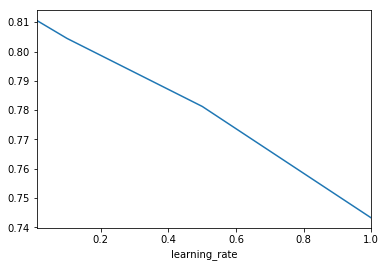

In [24]:
print(df1.groupby('learning_rate').mean())
df1.groupby('learning_rate').mean()['mean'].plot();

           learning_rate      mean  n_estimators       std
max_depth                                                 
5                 0.4025  0.786246         937.5  0.045452
6                 0.4025  0.781268         937.5  0.043841
7                 0.4025  0.788670         937.5  0.049170
8                 0.4025  0.783395         937.5  0.047656


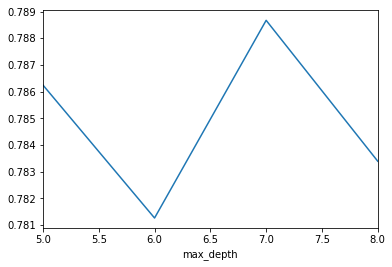

In [25]:
print(df1.groupby('max_depth').mean())
df1.groupby('max_depth').mean()['mean'].plot();

              learning_rate  max_depth      mean       std
n_estimators                                              
250                  0.4025        6.5  0.783664  0.046308
500                  0.4025        6.5  0.785410  0.045898
1000                 0.4025        6.5  0.785608  0.046738
2000                 0.4025        6.5  0.784897  0.047175


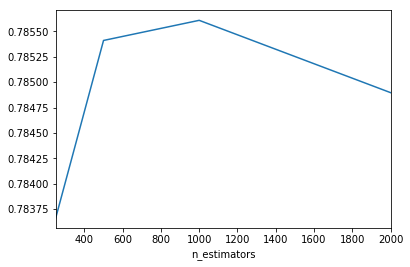

In [26]:
print(df1.groupby('n_estimators').mean())
df1.groupby('n_estimators').mean()['mean'].plot();

# MODEL GRID SEARCH

In [9]:
'''
MODEL PARAMS:

lag_type = ['roc', 'straight']
features = [20, 40, 60, 80]
timesteps = [4, 8, 12, 16, 20, 24]


XGBOOST PARAMS:

OLD:

'max_depth': [4, 6, 8, 10, 12],
'n_estimators': [250, 500, 1000, 1500, 2000]
'learning_rate': [0.001, 0.010, 0.100, 0.250]

NEW:

'max_depth': [6, 8, 10, 12, 15, 20],
'n_estimators': [500, 1000, 1500, 2000, 4000],
'learning_rate': [0.001, 0.010, 0.100, 0.250]


'''''''''

models = [
    
    # 20 FEATURES
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 4},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 4},
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 8},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 8},
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 12},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 12},
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 16},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 16},
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 20},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 20},
    
#     {'lag_type': 'roc', 'features': 20, 'timesteps': 24},
#     {'lag_type': 'straight', 'features': 20, 'timesteps': 24},
    
    
    
    # 40 FEATURES
    
#     {'lag_type': 'roc', 'features': 40, 'timesteps': 4},
#     {'lag_type': 'straight', 'features': 40, 'timesteps': 4},
    
#     {'lag_type': 'roc', 'features': 40, 'timesteps': 8},
#     {'lag_type': 'straight', 'features': 40, 'timesteps': 8},
    
#    {'lag_type': 'roc', 'features': 40, 'timesteps': 12},
    
    ####################################################################
    ### STARTED NEW PARAMS HERE
    ###########################
    #
    # Also, switched to only 'straight' lag due to stronger performance
    # &
    # hash on margin means complete. hash on indent means skipped.
    #
    ####################################################################
    
#    {'lag_type': 'straight', 'features': 40, 'timesteps': 12},
    
    #{'lag_type': 'roc', 'features': 40, 'timesteps': 16},
#    {'lag_type': 'straight', 'features': 40, 'timesteps': 16},
    
    #{'lag_type': 'roc', 'features': 40, 'timesteps': 20},
#    {'lag_type': 'straight', 'features': 40, 'timesteps': 20},
    
    #{'lag_type': 'roc', 'features': 40, 'timesteps': 24},
#    {'lag_type': 'straight', 'features': 40, 'timesteps': 24},
    
    
    
    # 60 FEATURES
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 4},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 4},
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 8},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 8},
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 12},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 12},
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 16},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 16},
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 20},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 20},
    
    #{'lag_type': 'roc', 'features': 60, 'timesteps': 24},
#    {'lag_type': 'straight', 'features': 60, 'timesteps': 24},
    
    
    
    
    # 80 FEATURES
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 4},
#    {'lag_type': 'straight', 'features': 80, 'timesteps': 4},
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 8},
    {'lag_type': 'straight', 'features': 80, 'timesteps': 8},
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 12},
    {'lag_type': 'straight', 'features': 80, 'timesteps': 12},
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 16},
    {'lag_type': 'straight', 'features': 80, 'timesteps': 16},
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 20},
    {'lag_type': 'straight', 'features': 80, 'timesteps': 20},
    
    #{'lag_type': 'roc', 'features': 80, 'timesteps': 24},
    {'lag_type': 'straight', 'features': 80, 'timesteps': 24}
    
]

In [6]:
'''
MODEL PARAMS:

lag_type = ['straight']
features = [20, 25, 30]
timesteps = [16, 20, 24, 28, 32, 36, 40]

Total: 21

XGBOOST PARAMS:

NEW:

'max_depth': [10, 15, 20, 25, 30, 35],
'n_estimators': [1000, 1500, 2000, 4000, 6000, 8000],
'learning_rate': [0.005, 0.010, 0.025, 0.050]

Total: 144
'''''''''

models = [
    
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 16},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 20},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 24},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 28},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 32},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 36},
#    {'lag_type': 'straight', 'features': 20, 'timesteps': 40},
    
#    {'lag_type': 'straight', 'features': 25, 'timesteps': 16},
#    {'lag_type': 'straight', 'features': 25, 'timesteps': 20},
#    {'lag_type': 'straight', 'features': 25, 'timesteps': 24},
#    {'lag_type': 'straight', 'features': 25, 'timesteps': 28},
#    {'lag_type': 'straight', 'features': 25, 'timesteps': 32},
    #{'lag_type': 'straight', 'features': 25, 'timesteps': 36},
    #{'lag_type': 'straight', 'features': 25, 'timesteps': 40},
    
#    {'lag_type': 'straight', 'features': 30, 'timesteps': 16},
#    {'lag_type': 'straight', 'features': 30, 'timesteps': 20},
#    {'lag_type': 'straight', 'features': 30, 'timesteps': 24},
#    {'lag_type': 'straight', 'features': 30, 'timesteps': 28},
#    {'lag_type': 'straight', 'features': 30, 'timesteps': 32},
    #{'lag_type': 'straight', 'features': 30, 'timesteps': 36},
    #{'lag_type': 'straight', 'features': 30, 'timesteps': 40},
    
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 16},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 20},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 24},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 28},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 32},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 36},
    #{'lag_type': 'straight', 'features': 15, 'timesteps': 40}

]

In [2]:
results_df = pd.DataFrame()
cv_folds = 6

for m in models:
    
    # fixed model params
    target = 'polo_usdteth_median_trade_price'
    periods_ahead = 4
    
    # variable model params
    n_timesteps = m['timesteps']
    features = m['features']
    if m['lag_type'] == 'roc': roc = True
    elif m['lag_type'] == 'straight': roc = False
    
    # set the model id
    id_tuple = (periods_ahead, m['lag_type'], features, n_timesteps)
    model_id = '6hrs_%ssteps_%s-lag_%sfeatures_%stimesteps' % id_tuple
    
    print('\n\n\n\n')
    print('starting', model_id)
    print('\n\n')

    # set variable hyperparamaters
    params_grid = {

        # primary
        'max_depth': [10, 15, 20, 25, 30, 35],
        'n_estimators': [1000, 1500, 2000, 3000, 4000, 6000, 8000],
        'learning_rate': [0.005, 0.010, 0.025, 0.050]
    
    }

    model_df = xgboost_grid_search(df,
                             _features = features,
                             _target = target,
                             _periods_ahead = periods_ahead,
                             n_timesteps = n_timesteps,
                             _roc = roc,
                             _params = params_grid,
                             cv_folds = cv_folds,
                             _scoring = 'roc_auc',
                             verbose = True
                            )
    
    model_df['model'] = model_id
    
    results_df = results_df.append(model_df)
    
    print('\n\n')
    print(results_df.to_dict('records'))
    print('\n\n')